# Import Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import stdev

import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import Bidirectional
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.regularizers import l1
from keras.regularizers import l2
from keras.regularizers import L1L2

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import datetime
import math
import pickle

# Define Functions

In [2]:
def Average(data):
    return sum(data) / len(data)

def convert_bit_lenght(data):        
    a = []
    for element in data:
        native_int = int(element)
        a.append(native_int.bit_length())
    return a

def normalize_series(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    scaled_data = (data - mean) / std
    return scaled_data

def inverse_normalize_series(scaled, original):
    # Mean and standard deviation of the original data
    mean = np.mean(original, axis=0)
    std = np.std(original, axis=0)

    # Inverse Z-score scaling
    original_data = scaled * std + mean
    original_data = np.round(original_data,0)
    return original_data

def model_forecast(model, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(series)
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = model.predict(ds)
   return forecast

# Read Dataset

In [3]:
data = pd.read_excel('ready_data_pax_bms 1 April - 19 Juli 2023.xlsx', index_col='Unnamed: 0')
data

DATE  PAX_BMS_T1  PAX_BMS_T2  PAX_BMS_T3
0    2023-04-01 00:00:00           0           8           0
1    2023-04-01 01:00:00           0           0           0
2    2023-04-01 02:00:00           0           0           0
3    2023-04-01 03:00:00           0           0           0
4    2023-04-01 04:00:00           0           0           0
...                  ...         ...         ...         ...
2635 2023-07-19 19:00:00          73         119          65
2636 2023-07-19 20:00:00          69          92          90
2637 2023-07-19 21:00:00          28          25          47
2638 2023-07-19 22:00:00           2           9          31
2639 2023-07-19 23:00:00           1           3           4

[2640 rows x 4 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2640 entries, 0 to 2639
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        2640 non-null   datetime64[ns]
 1   PAX_BMS_T1  2640 non-null   int64         
 2   PAX_BMS_T2  2640 non-null   int64         
 3   PAX_BMS_T3  2640 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 103.1 KB


In [5]:
data.describe()

DATE   PAX_BMS_T1   PAX_BMS_T2   PAX_BMS_T3
count                 2640  2640.000000  2640.000000  2640.000000
mean   2023-05-25 23:30:00    36.214773    75.382197    57.459470
min    2023-04-01 00:00:00     0.000000     0.000000     0.000000
25%    2023-04-28 11:45:00     0.000000     4.750000     2.000000
50%    2023-05-25 23:30:00    27.000000    69.000000    57.000000
75%    2023-06-22 11:15:00    65.000000   127.000000    96.000000
max    2023-07-19 23:00:00   194.000000   394.000000   227.000000
std                    NaN    36.695872    69.154799    50.794938

# Split data to training, validation and testing

split data with proportion 65% for training data, 30% for validation data and 5% for testing

In [6]:
n_lookback = 24  # length of input sequences (lookback period)
n_forecast = 24  # length of output sequences (forecast period)

In [7]:
SPLIT_TIME_TRAIN_REM = int(math.floor(0.65*((len(data))/24)) * 24) 
print(f'jumlah data training: {SPLIT_TIME_TRAIN_REM}')

jumlah data training: 1704


In [8]:
data_train = data[:SPLIT_TIME_TRAIN_REM].loc[:, data.columns!='DATE']
data_train = pd.DataFrame(data_train)
data_train.index = data[:SPLIT_TIME_TRAIN_REM]['DATE']

data_rem = data[SPLIT_TIME_TRAIN_REM:].loc[:, data.columns!='DATE']
data_rem = pd.DataFrame(data_rem)
data_rem.index = data[SPLIT_TIME_TRAIN_REM:]['DATE']

In [9]:
SPLIT_TIME_VAL_TEST = int(math.floor(0.87*((len(data_rem))/24)) * 24) 
SPLIT_TIME_VAL_TEST
print(f'jumlah data validation: {SPLIT_TIME_VAL_TEST}')
print(f'jumlah data validation: {len(data_rem) - SPLIT_TIME_VAL_TEST}')

jumlah data validation: 792
jumlah data validation: 144


In [10]:
data_val = data_rem[:SPLIT_TIME_VAL_TEST]
data_val = pd.DataFrame(data_val)

data_test = data_rem[SPLIT_TIME_VAL_TEST:]
data_test = pd.DataFrame(data_test)

In [11]:
# % of training set
print(f'data training -> {(len(data_train)/len(data)) * 100}%')
print(f'data validation -> {(len(data_val)/len(data)) * 100}%')
print(f'data testing -> {(len(data_test)/len(data)) * 100}%')

data training -> 64.54545454545455%
data validation -> 30.0%
data testing -> 5.454545454545454%


In [12]:
data_train

PAX_BMS_T1  PAX_BMS_T2  PAX_BMS_T3
DATE                                                   
2023-04-01 00:00:00           0           8           0
2023-04-01 01:00:00           0           0           0
2023-04-01 02:00:00           0           0           0
2023-04-01 03:00:00           0           0           0
2023-04-01 04:00:00           0           0           0
...                         ...         ...         ...
2023-06-10 19:00:00          68         107          78
2023-06-10 20:00:00          22          68          76
2023-06-10 21:00:00          27          62          19
2023-06-10 22:00:00           5           6          28
2023-06-10 23:00:00           0           3           4

[1704 rows x 3 columns]

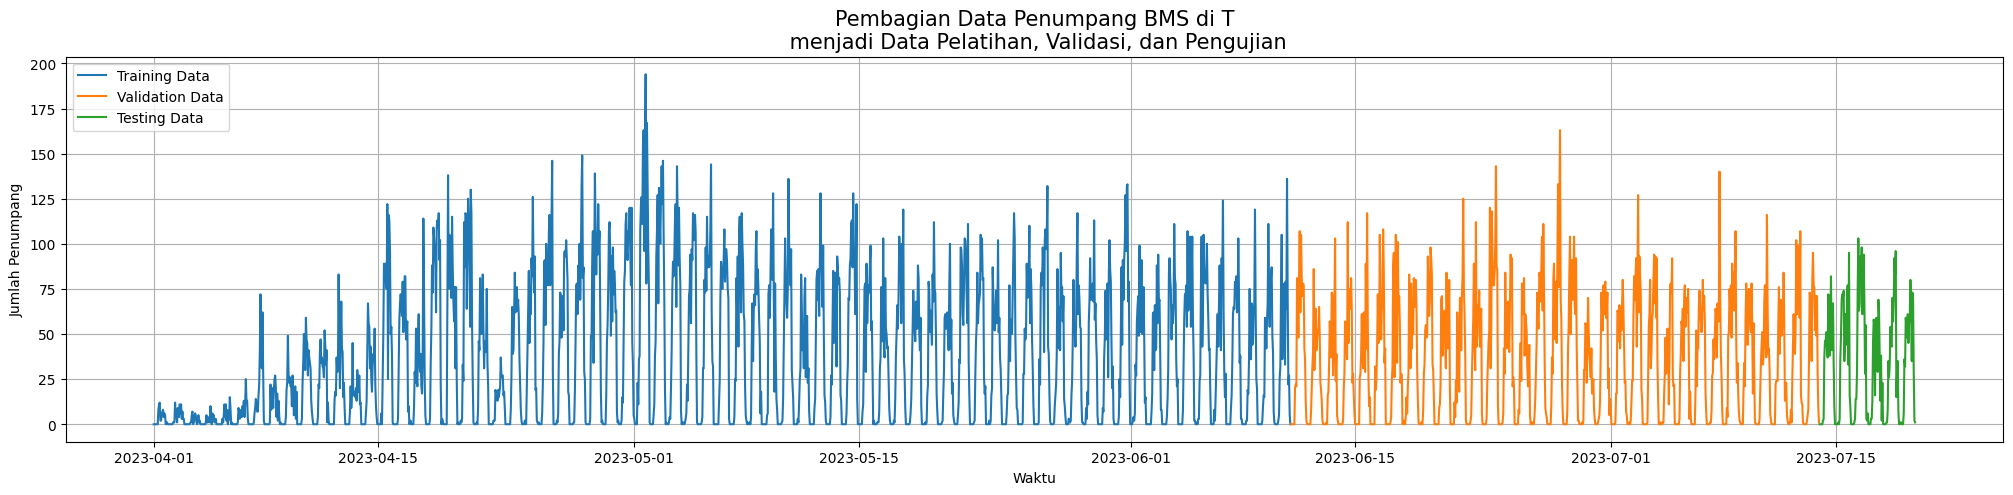

In [13]:
plt.subplots(figsize=(25, 5))
sns.lineplot(x="DATE", y="PAX_BMS_T1",
             data=data_train, label='Training Data')
sns.lineplot(x="DATE", y="PAX_BMS_T1",
             data=data_val, label='Validation Data')
sns.lineplot(x="DATE", y="PAX_BMS_T1",
             data=data_test, label='Testing Data')
plt.xlabel('Waktu'); plt.ylabel('Jumlah Penumpang')
plt.title("Pembagian Data Penumpang BMS di T\n menjadi Data Pelatihan, Validasi, dan Pengujian", fontsize = 15)
plt.grid()
plt.legend(loc='upper left')

## check sequence data

In [14]:
# paxBMS = data.values.reshape(-1, 1)

# paxBMS_train = data_train.values.reshape(-1, 1)
# paxBMS_val = data_val.values.reshape(-1, 1)
# paxBMS_test = data_test.values.reshape(-1, 1)

# print(paxBMS_train.shape);print(paxBMS_val.shape)

In [15]:
paxBMS = data.values

paxBMS_train = data_train.values
paxBMS_val = data_val.values
paxBMS_test = data_test.values

print(paxBMS_train.shape);print(paxBMS_val.shape)

(1704, 3)
(792, 3)


In [16]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxBMS_train) - n_forecast + 1):
    x_train.append(paxBMS_train[i - n_lookback: i])
    y_train.append(paxBMS_train[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 3)
(1657, 24, 3)


In [17]:
print(x_train[0]);print(y_train[0])

[[  0   8   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   2   0]
 [  0   1  11]
 [  8  30  53]
 [ 11  51  51]
 [ 12  70  81]
 [  2  46  61]
 [  2  22  93]
 [  5  34  59]
 [  7  41 104]
 [  8  89  83]
 [  4 105 128]
 [  6  33  83]
 [  5  56  77]
 [  0  17  41]
 [  1  62  48]
 [  1  25  29]
 [  0  12  26]
 [  0   0   8]
 [  0   0   0]]
[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  1   4   1]
 [  1  14   6]
 [  1  15  47]
 [ 12  43  47]
 [  5  93  45]
 [  5  70  72]
 [  1  28  78]
 [  9  33  51]
 [  6  46  78]
 [  4  71 107]
 [ 11  40 152]
 [  6  50  80]
 [ 11  78  65]
 [  3  33  32]
 [  7  23  26]
 [  3  20  33]
 [  3  10   9]
 [  0   7   5]
 [  0   0   1]]


In [18]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxBMS_val) - n_forecast + 1):
    x_val.append(paxBMS_val[i - n_lookback: i])
    y_val.append(paxBMS_val[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 3)
(745, 24, 3)


In [19]:
print(x_val[-1]);print(y_val[-1])

[[  2   0   6]
 [  0   7   0]
 [  0   0   0]
 [  0   0   0]
 [  2   0   0]
 [  8   5   2]
 [  1   7   2]
 [ 24  29  27]
 [ 43  65  55]
 [ 61 103  70]
 [ 45 132 115]
 [ 39  48  75]
 [ 54 104 125]
 [102 110 166]
 [ 61  65 105]
 [ 99 164 111]
 [ 67 122 103]
 [ 82 201 122]
 [ 59  95 114]
 [107 113 106]
 [ 16 130  67]
 [ 12  50  74]
 [ 11  22  12]
 [  1   3   9]]
[[  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]
 [  0   1   1]
 [  2   5   4]
 [  5  17   4]
 [  8  18  27]
 [ 34  88  41]
 [ 73 103  71]
 [ 71  90  73]
 [ 61 100 121]
 [ 35  94  99]
 [ 80 107 101]
 [ 95  80  93]
 [ 77 143 154]
 [ 76 154  83]
 [ 52 129 143]
 [ 71 156 102]
 [ 49 137 118]
 [ 71 149 148]
 [ 28 102  96]
 [  9  19  39]
 [  1   0  11]]


# Scaling / Normalize Data

In [20]:
np.std(paxBMS_train)

59.97935675620465

In [21]:
paxBMS_train

array([[ 0,  8,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [27, 62, 19],
       [ 5,  6, 28],
       [ 0,  3,  4]], dtype=int64)

In [22]:
scaled = normalize_series(paxBMS_train)
scaled

array([[-0.94141332, -0.97152489, -1.10934015],
       [-0.94141332, -1.07850249, -1.10934015],
       [-0.94141332, -1.07850249, -1.10934015],
       ...,
       [-0.24470053, -0.24942607, -0.74520611],
       [-0.81239244, -0.99826929, -0.57272157],
       [-0.94141332, -1.03838589, -1.03268036]])

In [23]:
original = inverse_normalize_series(scaled, paxBMS_train)
original

array([[ 0.,  8.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ...,
       [27., 62., 19.],
       [ 5.,  6., 28.],
       [ 0.,  3.,  4.]])

In [24]:
paxBMS_train_scaled = normalize_series(paxBMS_train)

paxBMS_val_scaled = normalize_series(paxBMS_val)

paxBMS_test_scaled = normalize_series(paxBMS_test)

## Set feature and label period

In [25]:
x_train = []
y_train = []

for i in range(n_lookback, len(paxBMS_train_scaled) - n_forecast + 1):
    x_train.append(paxBMS_train_scaled[i - n_lookback: i])
    y_train.append(paxBMS_train_scaled[i: i + n_forecast])

x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1657, 24, 3)
(1657, 24, 3)


In [26]:
x_val = []
y_val = []

for i in range(n_lookback, len(paxBMS_val_scaled) - n_forecast + 1):
    x_val.append(paxBMS_val_scaled[i - n_lookback: i])
    y_val.append(paxBMS_val_scaled[i: i + n_forecast])

x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)
print(y_val.shape)

(745, 24, 3)
(745, 24, 3)


In [27]:
y_train[0].shape

(24, 3)

# Vanilla GRU

## generate model

In [217]:
modelVanillaGRU = Sequential([
        GRU(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            input_shape=x_train[0].shape),                                          
        Flatten(),
        Dense(n_forecast * 3),
        Reshape([n_forecast, 3])
    ])

modelVanillaGRU.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_13 (GRU)                (None, 24, 64)            13248     
                                                                 
 flatten_13 (Flatten)        (None, 1536)              0         
                                                                 
 dense_13 (Dense)            (None, 72)                110664    
                                                                 
 reshape_2 (Reshape)         (None, 24, 3)             0         
                                                                 
Total params: 123,912
Trainable params: 123,912
Non-trainable params: 0
_________________________________________________________________


In [218]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelVanillaGRU.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [219]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v3/VanillaGRU-ModelAll.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [220]:
historyVanillaGRU = modelVanillaGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000


47/52 [==========================>...] - ETA: 0s - loss: 1.1403 - mse: 1.0111
Epoch 1: val_mse improved from inf to 0.97737, saving model to ./model v3\VanillaGRU-ModelAll.h5
52/52 [==============================] - 2s 13ms/step - loss: 1.1393 - mse: 1.0090 - val_loss: 1.1285 - val_mse: 0.9774
Epoch 2/1000
47/52 [==========================>...] - ETA: 0s - loss: 1.1139 - mse: 0.9651
Epoch 2: val_mse improved from 0.97737 to 0.93266, saving model to ./model v3\VanillaGRU-ModelAll.h5
52/52 [==============================] - 0s 9ms/step - loss: 1.1132 - mse: 0.9647 - val_loss: 1.1020 - val_mse: 0.9327
Epoch 3/1000
46/52 [=========================>....] - ETA: 0s - loss: 1.0896 - mse: 0.9252
Epoch 3: val_mse improved from 0.93266 to 0.88931, saving model to ./model v3\VanillaGRU-ModelAll.h5
52/52 [==============================] - 0s 9ms/step - loss: 1.0879 - mse: 0.9221 - val_loss: 1.0760 - val_mse: 0.8893
Epoch 4/1000
47/52 [==========================>...] - ETA: 0s - loss: 1.0635 - mse:

In [221]:
with open('./model v3/historyVanillaGRU', 'wb') as file_pi:
    pickle.dump(historyVanillaGRU.history, file_pi)

with open('./model v3/historyVanillaGRU', "rb") as file_pi:
    load_historyVanillaGRU = pickle.load(file_pi)

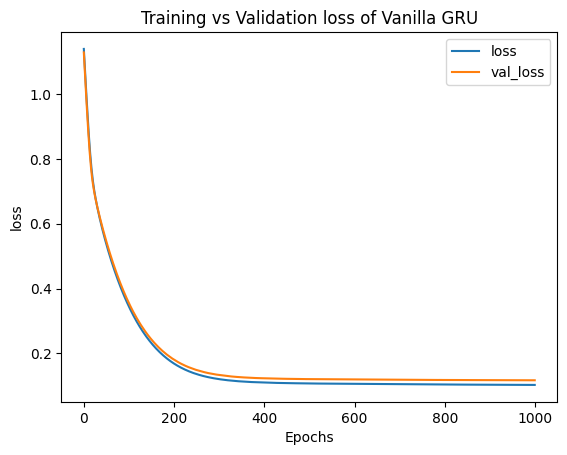

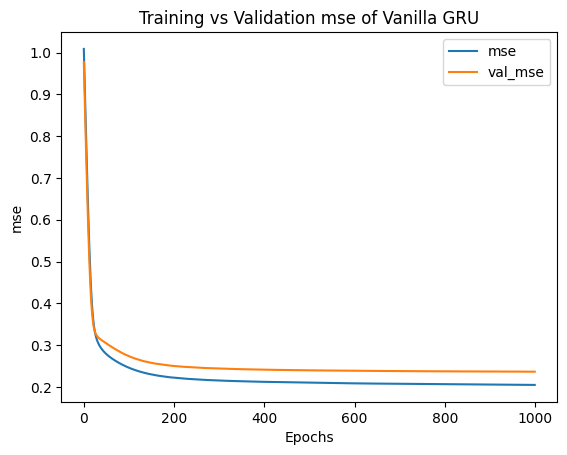

In [226]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyVanillaGRU, "loss")
plot_graphs(historyVanillaGRU, "mse")

## Prediction

### Prediction with training data

In [228]:
forecast_train_data = model_forecast(modelVanillaGRU, paxBMS_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxBMS_train_scaled.shape[0]-n_lookback)
forecast_train_data

      1/Unknown - 0s 26ms/step

1681/1681 [==============================] - 3s 2ms/step
(1681, 24, 3)
(1680, 3)
1680


array([[-1.0267004 , -1.1532425 , -1.227462  ],
       [-1.0326271 , -1.1956698 , -1.1761527 ],
       [-1.0131618 , -1.1400336 , -1.048481  ],
       ...,
       [-0.24782705,  0.07755293,  0.10982801],
       [-0.7686061 , -0.754366  , -0.68251944],
       [-1.0454625 , -1.0744045 , -1.0912485 ]], dtype=float32)

In [229]:
paxBMS_train[24:]

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [27, 62, 19],
       [ 5,  6, 28],
       [ 0,  3,  4]], dtype=int64)

In [230]:
original = inverse_normalize_series(forecast_train_data, paxBMS_train)
original

array([[-3., -6., -6.],
       [-4., -9., -3.],
       [-3., -5.,  3.],
       ...,
       [27., 86., 64.],
       [ 7., 24., 22.],
       [-4.,  0.,  1.]])

In [231]:
actual = np.squeeze(paxBMS_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [256]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

1680


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  3],
       ...,
       [27, 86, 64],
       [ 7, 24, 22],
       [ 0,  0,  1]])

In [257]:
df_train = pd.DataFrame()
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index

df_train['Actual_T1'] = actual[:,0]
df_train['Actual_T2'] = actual[:,1]
df_train['Actual_T3'] = actual[:,2]

df_train['Forecast_T1'] = corrected_forecast[:,0]
df_train['Forecast_T2'] = corrected_forecast[:,1]
df_train['Forecast_T3'] = corrected_forecast[:,2]

df_train

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0    2023-04-02 00:00:00          0          0          0            0  \
1    2023-04-02 01:00:00          0          0          0            0   
2    2023-04-02 02:00:00          0          0          0            0   
3    2023-04-02 03:00:00          0          0          0            0   
4    2023-04-02 04:00:00          0          0          0            0   
...                  ...        ...        ...        ...          ...   
1675 2023-06-10 19:00:00         68        107         78           66   
1676 2023-06-10 20:00:00         22         68         76           49   
1677 2023-06-10 21:00:00         27         62         19           27   
1678 2023-06-10 22:00:00          5          6         28            7   
1679 2023-06-10 23:00:00          0          3          4            0   

      Forecast_T2  Forecast_T3  
0               0            0  
1               0            0  
2               0            3  
3               2            6  
4               6            8  
...           ...          ...  
1675          162           98  
1676          132           93  
1677           86           64  
1678           24           22  
1679            0            1  

[1680 rows x 7 columns]

### Visualisasi Training Data

#### Visualisasi T1

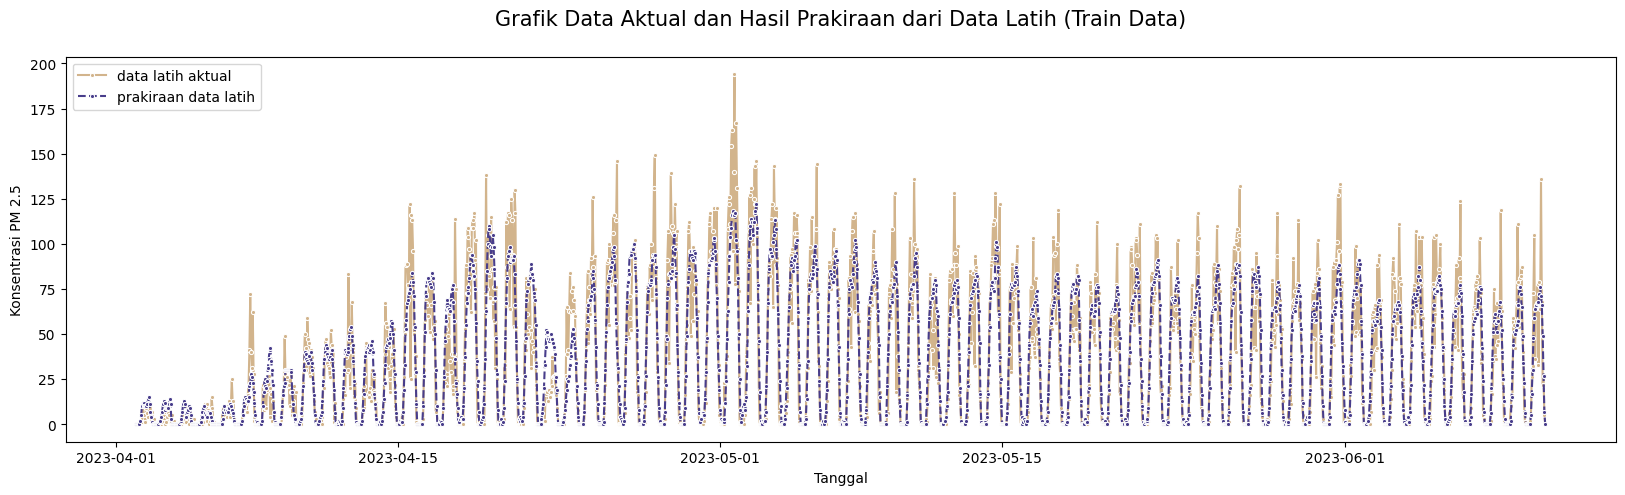

In [258]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [259]:
rmse = mean_squared_error(df_train['Forecast_T1'], df_train['Actual_T1'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T1'], df_train['Actual_T1'])
mape = mean_absolute_percentage_error(df_train['Forecast_T1'], df_train['Actual_T1'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  16.92
MAE:  10.84
MAPE:  292197832966300.3


#### Visualisasi T2

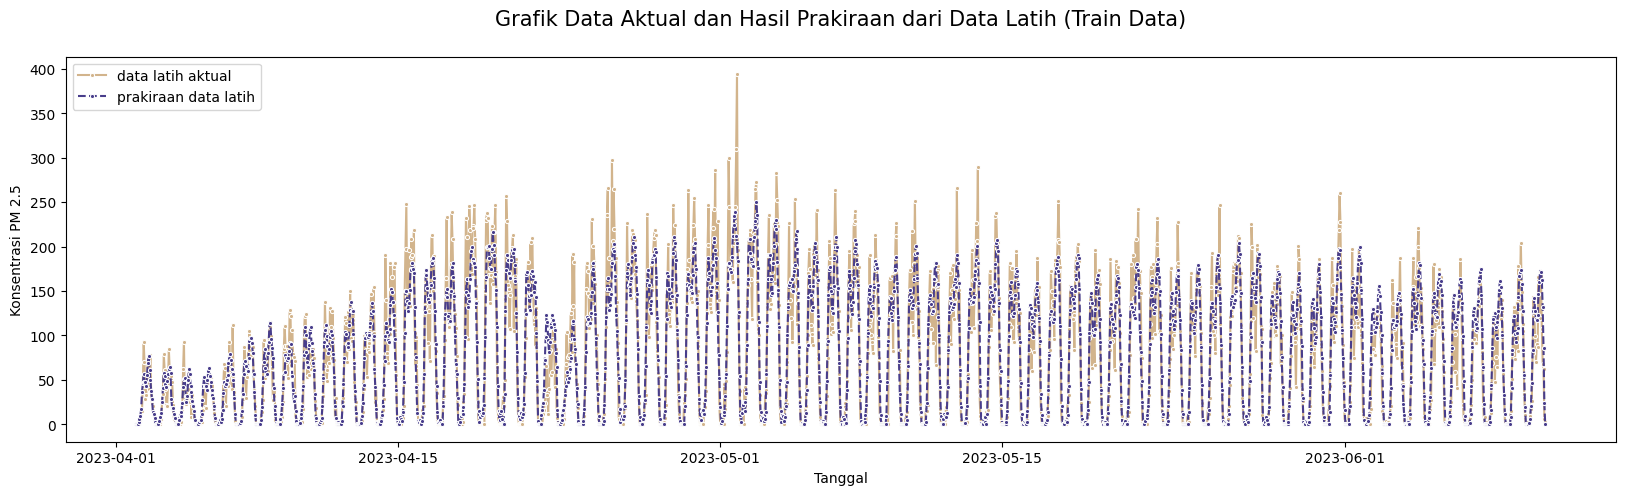

In [265]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [266]:
rmse = mean_squared_error(df_train['Forecast_T2'], df_train['Actual_T2'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T2'], df_train['Actual_T2'])
mape = mean_absolute_percentage_error(df_train['Forecast_T2'], df_train['Actual_T2'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  27.78
MAE:  18.88
MAPE:  881954927026722.5


#### Visualisasi T3

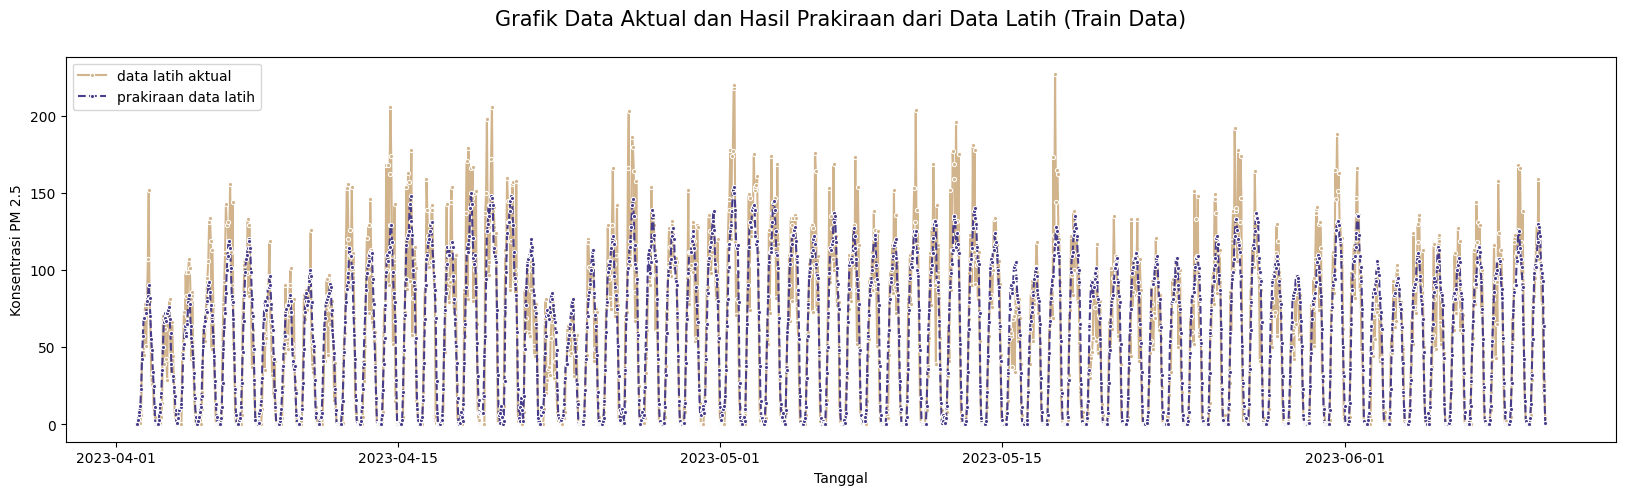

In [267]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [268]:
rmse = mean_squared_error(df_train['Forecast_T3'], df_train['Actual_T3'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T3'], df_train['Actual_T3'])
mape = mean_absolute_percentage_error(df_train['Forecast_T3'], df_train['Actual_T3'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  21.78
MAE:  14.83
MAPE:  302920689221944.44


### Prediction with validation data

In [270]:
forecast_val_data = model_forecast(modelVanillaGRU, paxBMS_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxBMS_val_scaled.shape[0]-n_lookback)
forecast_val_data

      1/Unknown - 0s 27ms/step

769/769 [==============================] - 2s 2ms/step
(769, 24, 3)
(768, 3)
768


array([[-1.1524212 , -1.2890275 , -1.2025896 ],
       [-1.2046857 , -1.3638425 , -1.3221585 ],
       [-1.0985733 , -1.2694553 , -1.2866873 ],
       ...,
       [-0.09906522,  0.15191555,  0.35143402],
       [-0.36462602, -0.2851865 , -0.17669675],
       [-0.7923689 , -0.81253254, -0.73842317]], dtype=float32)

In [271]:
paxBMS_val[24:]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       ...,
       [ 28, 102,  96],
       [  9,  19,  39],
       [  1,   0,  11]], dtype=int64)

In [272]:
original = inverse_normalize_series(forecast_val_data, paxBMS_val)
original

array([[ -2.,  -7.,  -1.],
       [ -4., -11.,  -7.],
       [ -0.,  -5.,  -5.],
       ...,
       [ 33.,  76.,  73.],
       [ 24.,  51.,  48.],
       [ 10.,  21.,  21.]])

In [273]:
actual = np.squeeze(paxBMS_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [274]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

768


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [33, 76, 73],
       [24, 51, 48],
       [10, 21, 21]])

In [275]:
df_val = pd.DataFrame()
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index

df_val['Actual_T1'] = actual[:,0]
df_val['Actual_T2'] = actual[:,1]
df_val['Actual_T3'] = actual[:,2]

df_val['Forecast_T1'] = corrected_forecast[:,0]
df_val['Forecast_T2'] = corrected_forecast[:,1]
df_val['Forecast_T3'] = corrected_forecast[:,2]

df_val

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-06-12 00:00:00          0          0          0            0  \
1   2023-06-12 01:00:00          0          0          0            0   
2   2023-06-12 02:00:00          0          0          0            0   
3   2023-06-12 03:00:00          0          0          0            3   
4   2023-06-12 04:00:00          0          0          0            3   
..                  ...        ...        ...        ...          ...   
763 2023-07-13 19:00:00         49        137        118           64   
764 2023-07-13 20:00:00         71        149        148           46   
765 2023-07-13 21:00:00         28        102         96           33   
766 2023-07-13 22:00:00          9         19         39           24   
767 2023-07-13 23:00:00          1          0         11           10   

     Forecast_T2  Forecast_T3  
0              0            0  
1              0            0  
2              0            0  
3              1            0  
4              3            2  
..           ...          ...  
763          132           94  
764          102           85  
765           76           73  
766           51           48  
767           21           21  

[768 rows x 7 columns]

### Visualisasi validation data

#### Visualisasi T1

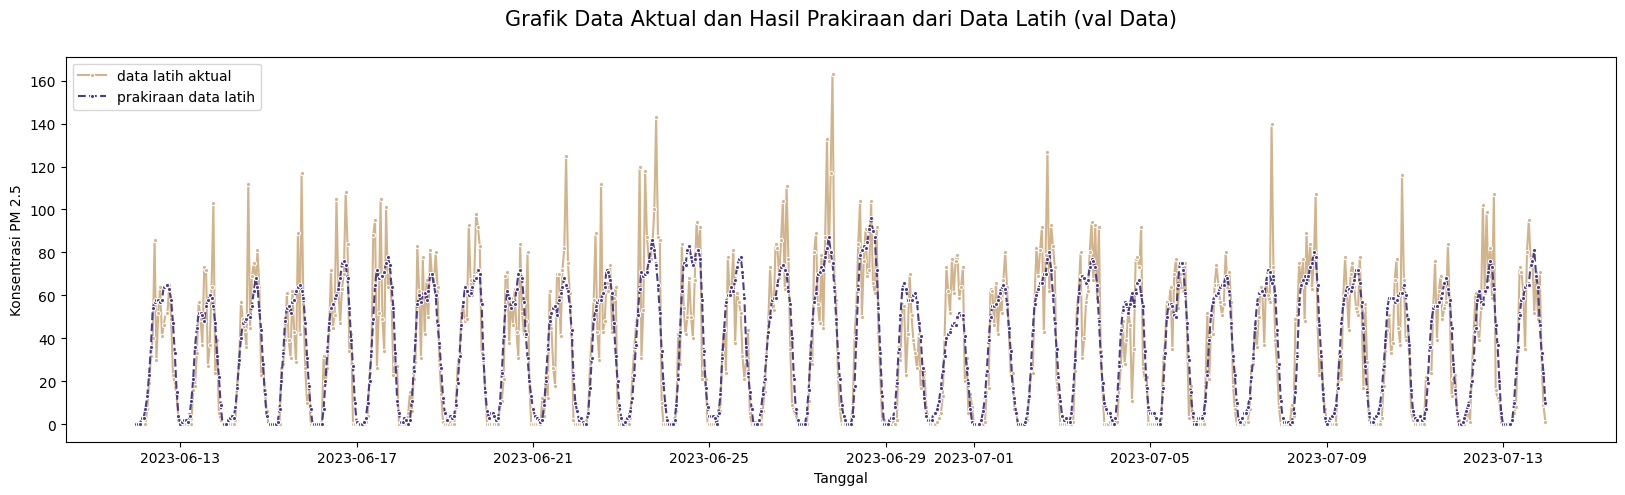

In [276]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [279]:
rmse = mean_squared_error(df_val['Forecast_T1'], df_val['Actual_T1'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T1'], df_val['Actual_T1'])
mape = mean_absolute_percentage_error(df_val['Forecast_T1'], df_val['Actual_T1'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  16.66
MAE:  11.65


#### Visualisasi T2

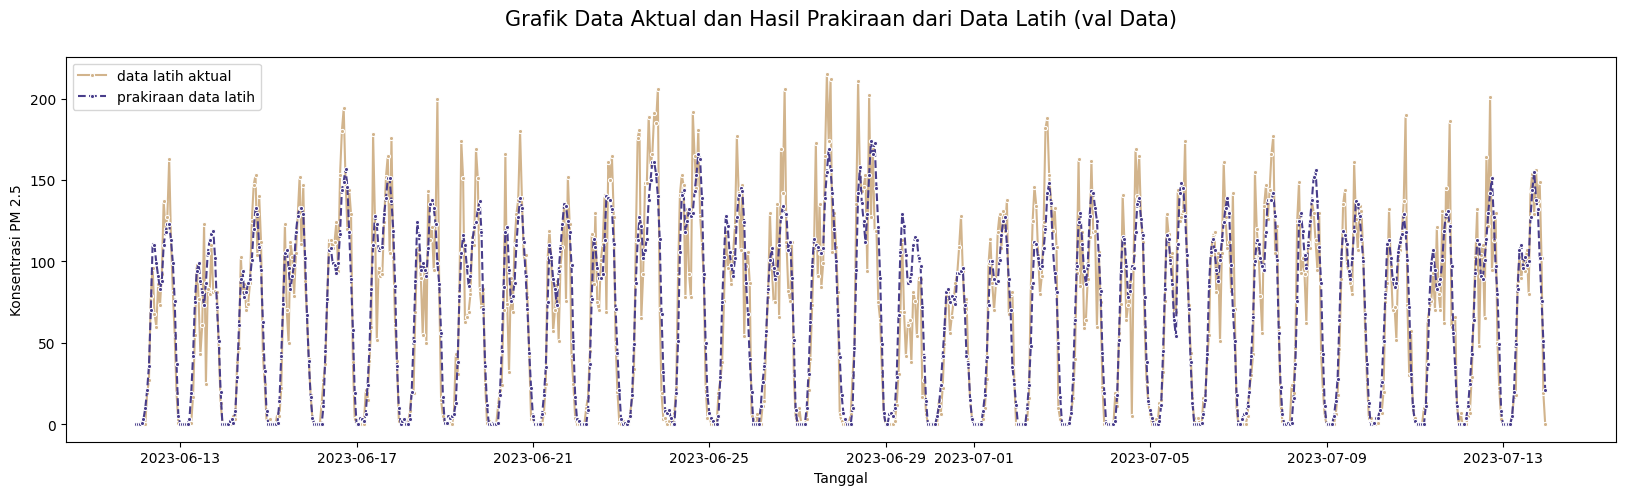

In [280]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [281]:
rmse = mean_squared_error(df_val['Forecast_T2'], df_val['Actual_T2'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T2'], df_val['Actual_T2'])
mape = mean_absolute_percentage_error(df_val['Forecast_T2'], df_val['Actual_T2'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  23.88
MAE:  16.6


#### Visualisasi T3

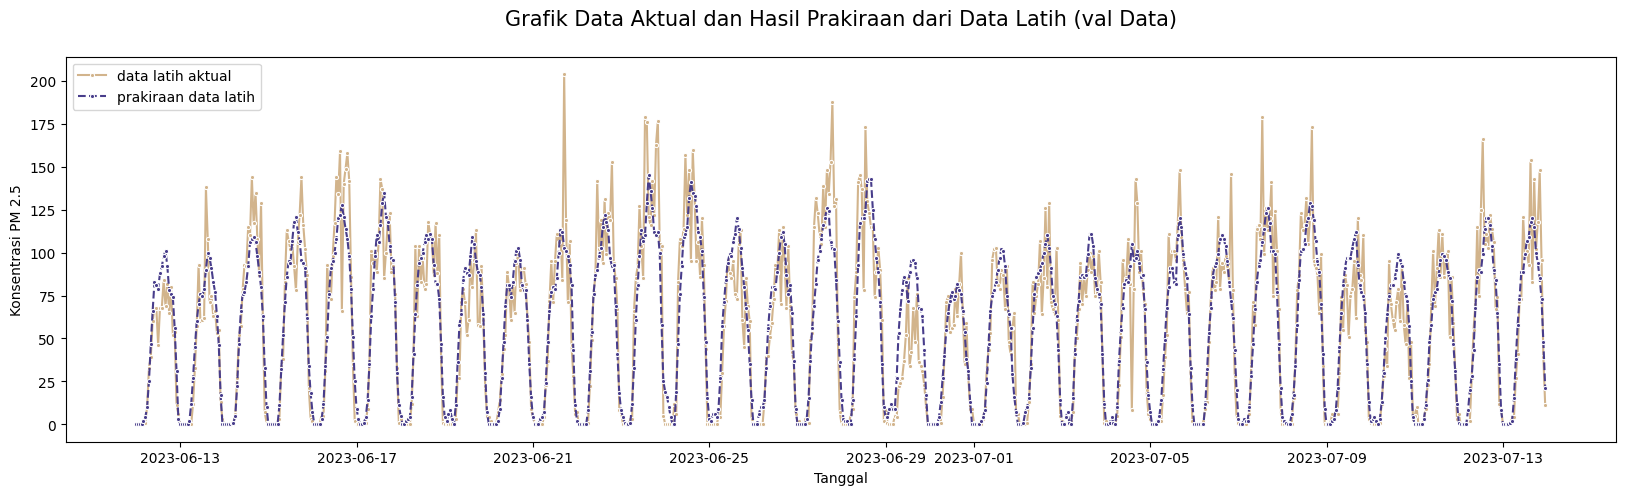

In [282]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [284]:
rmse = mean_squared_error(df_val['Forecast_T3'], df_val['Actual_T3'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T3'], df_val['Actual_T3'])
mape = mean_absolute_percentage_error(df_val['Forecast_T3'], df_val['Actual_T3'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  19.77
MAE:  13.51


### Prediction with testing data

In [285]:
forecast_test_data = model_forecast(modelVanillaGRU, paxBMS_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxBMS_test_scaled.shape[0]-n_lookback)
forecast_test_data

121/121 [==============================] - 0s 2ms/step
(121, 24, 3)
(120, 3)
120


array([[-0.9661271 , -1.0656223 , -1.0392703 ],
       [-1.0753837 , -1.1730151 , -1.1201591 ],
       [-1.1009045 , -1.1552728 , -1.1207203 ],
       [-1.1159532 , -1.1784636 , -1.0588696 ],
       [-1.1235777 , -1.2098086 , -1.0814801 ],
       [-0.9998779 , -1.1110382 , -1.1025915 ],
       [-0.7847419 , -0.799858  , -0.822072  ],
       [-0.35438842, -0.21499884, -0.26769236],
       [ 0.10285548,  0.49300033,  0.27340344],
       [ 0.5714943 ,  1.0537899 ,  0.6248278 ],
       [ 0.7659998 ,  0.9875874 ,  0.8009721 ],
       [ 0.86944133,  0.82795393,  1.0716289 ],
       [ 1.1115015 ,  0.8221439 ,  1.225275  ],
       [ 1.2002256 ,  0.84766066,  1.3794265 ],
       [ 1.2249609 ,  0.91934204,  1.5195081 ],
       [ 1.191378  ,  1.1082892 ,  1.5942338 ],
       [ 0.8970839 ,  0.9753018 ,  1.1112862 ],
       [ 0.9299109 ,  1.2331642 ,  1.0081763 ],
       [ 0.9187196 ,  1.2993504 ,  0.86857325],
       [ 0.9005359 ,  1.3022617 ,  0.6842703 ],
       [ 0.37283257,  0.7681557 ,  0.418

In [286]:
paxBMS_test[24:]

array([[  0,   0,   1],
       [  0,   0,   1],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  0,   9,   3],
       [  3,  23,   8],
       [ 36,  40,  27],
       [ 49,  75,  79],
       [ 69,  95,  71],
       [ 72,  83, 188],
       [ 70, 119, 111],
       [ 74,  95, 110],
       [ 35, 105, 132],
       [ 46,  85,  87],
       [ 61,  11,  20],
       [ 44, 110,  85],
       [ 72, 130, 148],
       [ 77, 133,  68],
       [ 33,  75,  82],
       [ 95, 138,  79],
       [ 16,  54,  46],
       [ 10,  52,  42],
       [  0,   0,   2],
       [  0,   6,   3],
       [  0,   6,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  3,  20,   0],
       [ 14,   7,   4],
       [ 14,  35,  42],
       [ 29,  55,  94],
       [ 75, 129,  79],
       [103,  98,  98],
       [ 63,  66, 102],
       [ 67,  84,  85],
       [ 93,  93,  77],
       [ 82,  53, 114],
       [ 98, 137, 136],
       [ 61, 125, 113],
       [ 82, 162

In [287]:
original = inverse_normalize_series(forecast_test_data, paxBMS_test)
original

array([[  5.,   5.,   8.],
       [  1.,  -1.,   4.],
       [  1.,   0.,   4.],
       [  0.,  -1.,   7.],
       [ -0.,  -3.,   6.],
       [  4.,   2.,   5.],
       [ 10.,  18.,  18.],
       [ 23.,  48.,  45.],
       [ 37.,  84.,  71.],
       [ 51., 112.,  88.],
       [ 57., 109.,  96.],
       [ 60., 101., 109.],
       [ 68., 100., 117.],
       [ 70., 102., 124.],
       [ 71., 105., 131.],
       [ 70., 115., 135.],
       [ 61., 108., 111.],
       [ 62., 121., 106.],
       [ 62., 124., 100.],
       [ 61., 125.,  91.],
       [ 45.,  97.,  78.],
       [ 38.,  81.,  66.],
       [ 16.,  32.,  36.],
       [  4.,   8.,   7.],
       [  2.,  -4.,   2.],
       [  2.,   1.,  -2.],
       [  8.,   8.,  -2.],
       [ 10.,   8.,   6.],
       [ 10.,   5.,   9.],
       [  9.,   7.,   8.],
       [ 14.,  18.,  19.],
       [ 22.,  37.,  41.],
       [ 32.,  70.,  61.],
       [ 46.,  97.,  75.],
       [ 60., 114.,  99.],
       [ 67., 116., 105.],
       [ 64., 101., 105.],
 

In [288]:
actual = np.squeeze(paxBMS_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120, 3)
[[0 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 0 0]]


In [289]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

120


array([[  5,   5,   8],
       [  1,   0,   4],
       [  1,   0,   4],
       [  0,   0,   7],
       [  0,   0,   6],
       [  4,   2,   5],
       [ 10,  18,  18],
       [ 23,  48,  45],
       [ 37,  84,  71],
       [ 51, 112,  88],
       [ 57, 109,  96],
       [ 60, 101, 109],
       [ 68, 100, 117],
       [ 70, 102, 124],
       [ 71, 105, 131],
       [ 70, 115, 135],
       [ 61, 108, 111],
       [ 62, 121, 106],
       [ 62, 124, 100],
       [ 61, 125,  91],
       [ 45,  97,  78],
       [ 38,  81,  66],
       [ 16,  32,  36],
       [  4,   8,   7],
       [  2,   0,   2],
       [  2,   1,   0],
       [  8,   8,   0],
       [ 10,   8,   6],
       [ 10,   5,   9],
       [  9,   7,   8],
       [ 14,  18,  19],
       [ 22,  37,  41],
       [ 32,  70,  61],
       [ 46,  97,  75],
       [ 60, 114,  99],
       [ 67, 116, 105],
       [ 64, 101, 105],
       [ 60,  84, 104],
       [ 59,  78, 100],
       [ 58,  82,  97],
       [ 74, 124, 115],
       [ 75, 131

In [290]:
df_test = pd.DataFrame()
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index

df_test['Actual_T1'] = actual[:,0]
df_test['Actual_T2'] = actual[:,1]
df_test['Actual_T3'] = actual[:,2]

df_test['Forecast_T1'] = corrected_forecast[:,0]
df_test['Forecast_T2'] = corrected_forecast[:,1]
df_test['Forecast_T3'] = corrected_forecast[:,2]

df_test

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-07-15 00:00:00          0          0          1            5  \
1   2023-07-15 01:00:00          0          0          1            1   
2   2023-07-15 02:00:00          0          0          0            1   
3   2023-07-15 03:00:00          0          0          0            0   
4   2023-07-15 04:00:00          1          0          0            0   
..                  ...        ...        ...        ...          ...   
115 2023-07-19 19:00:00         73        119         65           42   
116 2023-07-19 20:00:00         69         92         90           33   
117 2023-07-19 21:00:00         28         25         47           28   
118 2023-07-19 22:00:00          2          9         31           14   
119 2023-07-19 23:00:00          1          3          4            4   

     Forecast_T2  Forecast_T3  
0              5            8  
1              0            4  
2              0            4  
3              0            7  
4              0            6  
..           ...          ...  
115           86           81  
116           71           73  
117           59           58  
118           27           25  
119            0            2  

[120 rows x 7 columns]

### Visualisasi testing data

#### Visualisasi T1

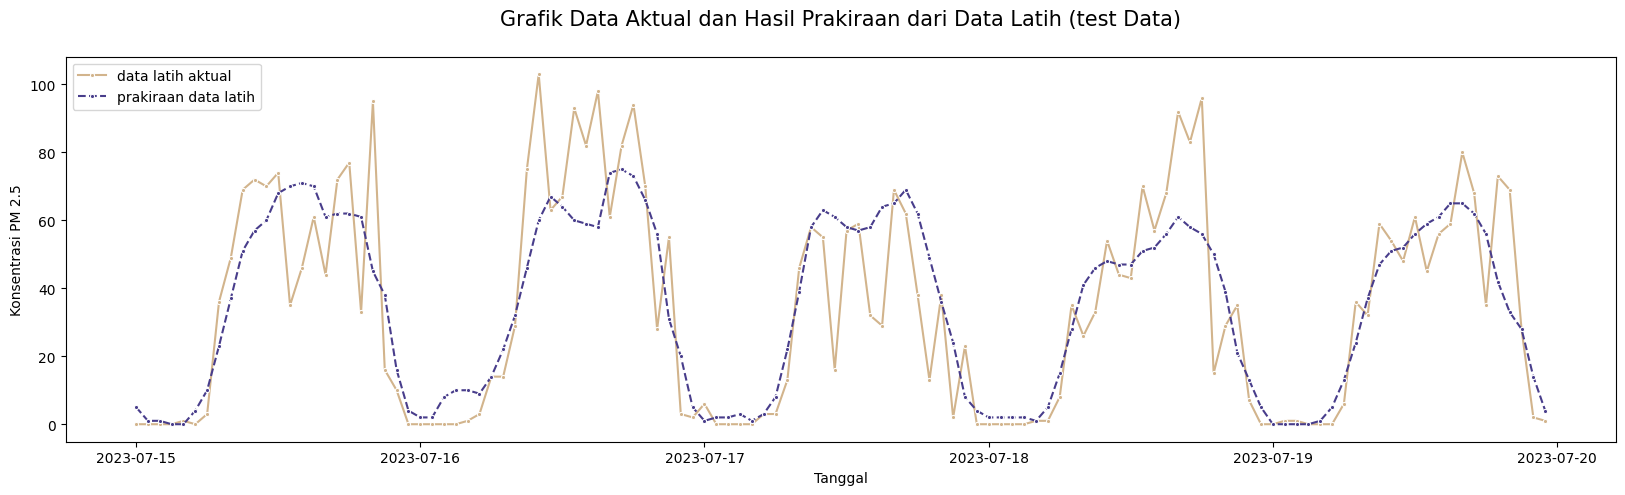

In [291]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [292]:
rmse = mean_squared_error(df_test['Forecast_T1'], df_test['Actual_T1'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T1'], df_test['Actual_T1'])
mape = mean_absolute_percentage_error(df_test['Forecast_T1'], df_test['Actual_T1'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  16.49
MAE:  11.61
MAPE:  112589990684262.9


#### Visualisasi T2

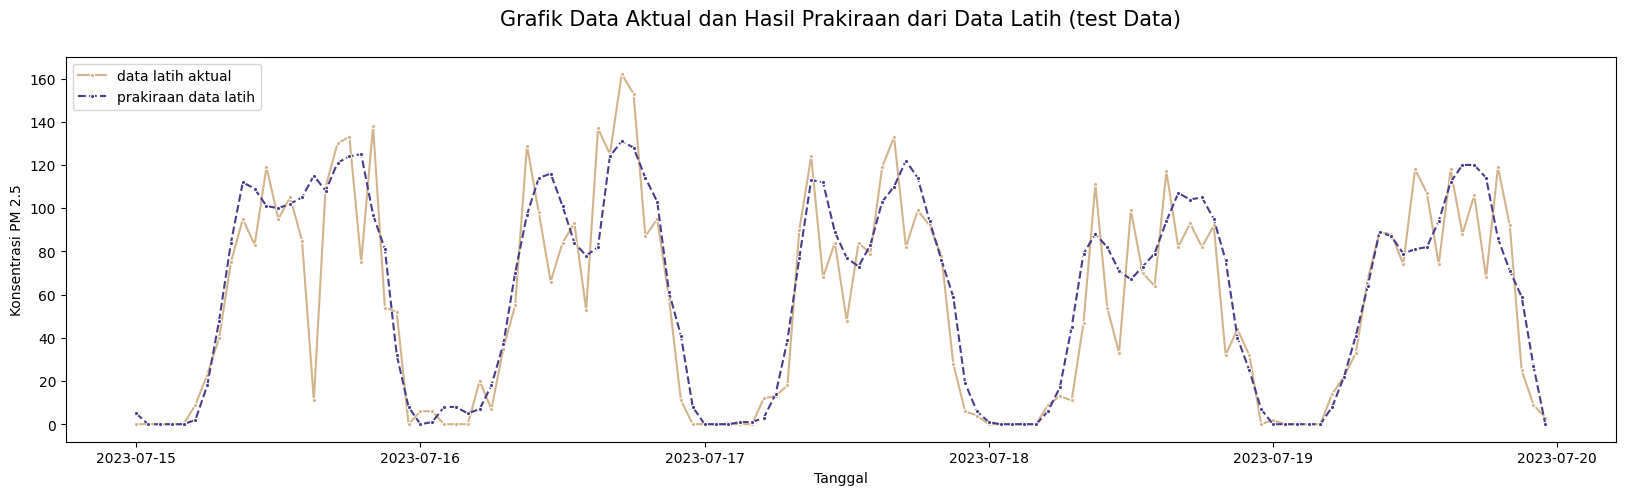

In [293]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [295]:
rmse = mean_squared_error(df_test['Forecast_T2'], df_test['Actual_T2'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T2'], df_test['Actual_T2'])
mape = mean_absolute_percentage_error(df_test['Forecast_T2'], df_test['Actual_T2'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  21.74
MAE:  14.76


#### Visualisasi T3

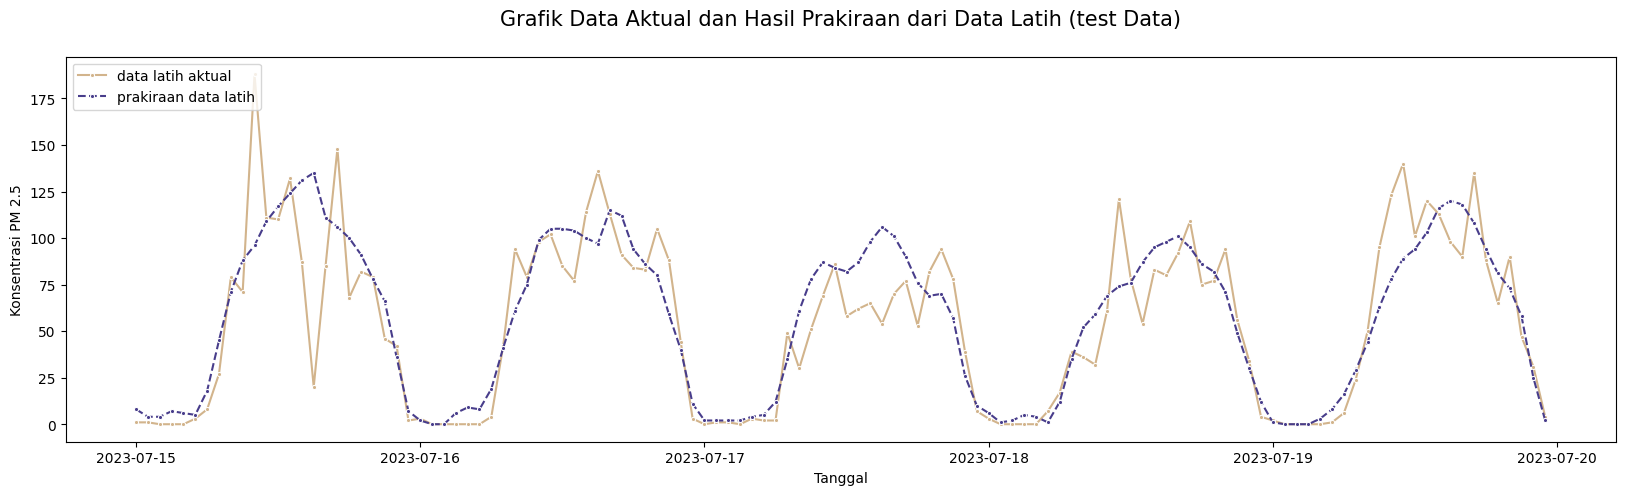

In [296]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [297]:
rmse = mean_squared_error(df_test['Forecast_T3'], df_test['Actual_T3'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T3'], df_test['Actual_T3'])
mape = mean_absolute_percentage_error(df_test['Forecast_T3'], df_test['Actual_T3'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  22.45
MAE:  14.64


# Bidirectional GRU

## generate model

In [298]:
modelBiGRU = Sequential([
        Bidirectional(GRU(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True,
            ),input_shape=x_train[0].shape),                                   
        Flatten(),
        Dense(n_forecast * 3),
        Reshape([n_forecast, 3])
    ])

modelBiGRU.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 24, 128)          26496     
 l)                                                              
                                                                 
 flatten_14 (Flatten)        (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 72)                221256    
                                                                 
 reshape_3 (Reshape)         (None, 24, 3)             0         
                                                                 
Total params: 247,752
Trainable params: 247,752
Non-trainable params: 0
_________________________________________________________________


In [299]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
modelBiGRU.compile(loss=tf.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])

In [300]:
estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,verbose=1,
                                       restore_best_weights=True)
mc=tf.keras.callbacks.ModelCheckpoint('./model v3/BiGRU-ModelAll.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [301]:
historyBiGRU = modelBiGRU.fit(
    x_train, y_train, 
    epochs=1000, 
    batch_size=32, 
    callbacks=[estop, mc],
    validation_data=(x_val,y_val))

Epoch 1/1000
52/52 [==============================] - ETA: 0s - loss: 1.8300 - mse: 0.9868
Epoch 1: val_mse improved from inf to 0.94238, saving model to ./model v3\BiGRU-ModelAll.h5
52/52 [==============================] - 4s 27ms/step - loss: 1.8300 - mse: 0.9868 - val_loss: 1.8091 - val_mse: 0.9424
Epoch 2/1000
49/52 [===========================>..] - ETA: 0s - loss: 1.7818 - mse: 0.9067
Epoch 2: val_mse improved from 0.94238 to 0.86656, saving model to ./model v3\BiGRU-ModelAll.h5
52/52 [==============================] - 1s 19ms/step - loss: 1.7822 - mse: 0.9097 - val_loss: 1.7612 - val_mse: 0.8666
Epoch 3/1000
49/52 [===========================>..] - ETA: 0s - loss: 1.7384 - mse: 0.8420
Epoch 3: val_mse improved from 0.86656 to 0.79550, saving model to ./model v3\BiGRU-ModelAll.h5
52/52 [==============================] - 1s 19ms/step - loss: 1.7362 - mse: 0.8374 - val_loss: 1.7151 - val_mse: 0.7955
Epoch 4/1000
49/52 [===========================>..] - ETA: 0s - loss: 1.6928 - mse:

In [302]:
with open('./model v3/historyBiGRU', 'wb') as file_pi:
    pickle.dump(historyBiGRU.history, file_pi)

with open('./model v3/historyBiGRU', "rb") as file_pi:
    load_historyBiGRU = pickle.load(file_pi)

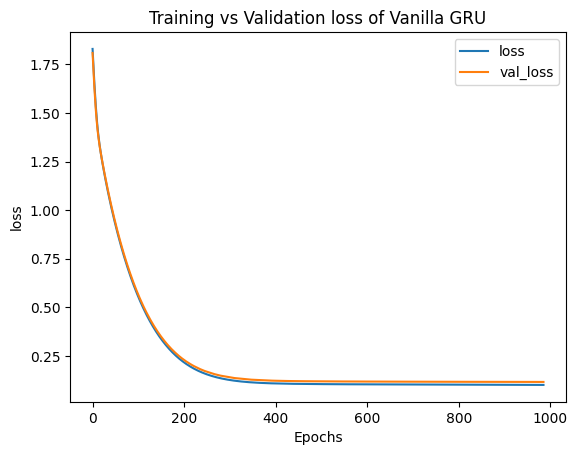

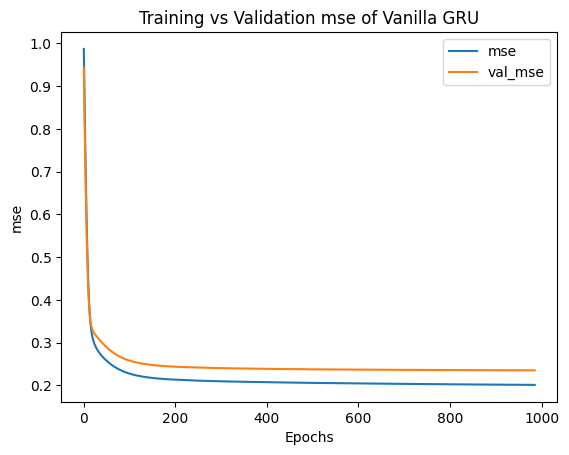

In [303]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"Training vs Validation {metric} of Vanilla GRU")
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(historyBiGRU, "loss")
plot_graphs(historyBiGRU, "mse")

## Prediction

In [28]:
modelBiGRU = tf.keras.models.load_model('./model v3/BiGRU-ModelAll.h5')

### Prediction with training data

In [29]:
forecast_train_data = model_forecast(modelBiGRU, paxBMS_train_scaled, n_lookback, 1)
print(forecast_train_data.shape)

forecast_train_data = forecast_train_data[:-1, 0]
print(forecast_train_data.shape)
print(paxBMS_train_scaled.shape[0]-n_lookback)
forecast_train_data

1681/1681 [==============================] - 9s 5ms/step
(1681, 24, 3)
(1680, 3)
1680


array([[-1.0218412 , -1.1480936 , -1.2550094 ],
       [-1.0127356 , -1.1920823 , -1.1852981 ],
       [-0.9787981 , -1.1231529 , -1.0602205 ],
       ...,
       [-0.30203125, -0.02517061,  0.05558477],
       [-0.78688264, -0.7942596 , -0.7517053 ],
       [-1.0406519 , -1.113986  , -1.1385758 ]], dtype=float32)

In [30]:
paxBMS_train[24:]

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [27, 62, 19],
       [ 5,  6, 28],
       [ 0,  3,  4]], dtype=int64)

In [31]:
original = inverse_normalize_series(forecast_train_data, paxBMS_train)
original

array([[-3., -5., -8.],
       [-3., -8., -4.],
       [-1., -3.,  3.],
       ...,
       [25., 79., 61.],
       [ 6., 21., 19.],
       [-4., -3., -2.]])

In [32]:
actual = np.squeeze(paxBMS_train[-forecast_train_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(1680, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [33]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

1680


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  3],
       ...,
       [25, 79, 61],
       [ 6, 21, 19],
       [ 0,  0,  0]])

In [34]:
df_train = pd.DataFrame()
df_train['Date'] = data_train[-forecast_train_data.shape[0]:].index

df_train['Actual_T1'] = actual[:,0]
df_train['Actual_T2'] = actual[:,1]
df_train['Actual_T3'] = actual[:,2]

df_train['Forecast_T1'] = corrected_forecast[:,0]
df_train['Forecast_T2'] = corrected_forecast[:,1]
df_train['Forecast_T3'] = corrected_forecast[:,2]

df_train

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0    2023-04-02 00:00:00          0          0          0            0  \
1    2023-04-02 01:00:00          0          0          0            0   
2    2023-04-02 02:00:00          0          0          0            0   
3    2023-04-02 03:00:00          0          0          0            0   
4    2023-04-02 04:00:00          0          0          0            0   
...                  ...        ...        ...        ...          ...   
1675 2023-06-10 19:00:00         68        107         78           69   
1676 2023-06-10 20:00:00         22         68         76           49   
1677 2023-06-10 21:00:00         27         62         19           25   
1678 2023-06-10 22:00:00          5          6         28            6   
1679 2023-06-10 23:00:00          0          3          4            0   

      Forecast_T2  Forecast_T3  
0               0            0  
1               0            0  
2               0            3  
3               2            6  
4               5            7  
...           ...          ...  
1675          164          100  
1676          130           94  
1677           79           61  
1678           21           19  
1679            0            0  

[1680 rows x 7 columns]

### Visualisasi Training Data

#### Visualisasi T1

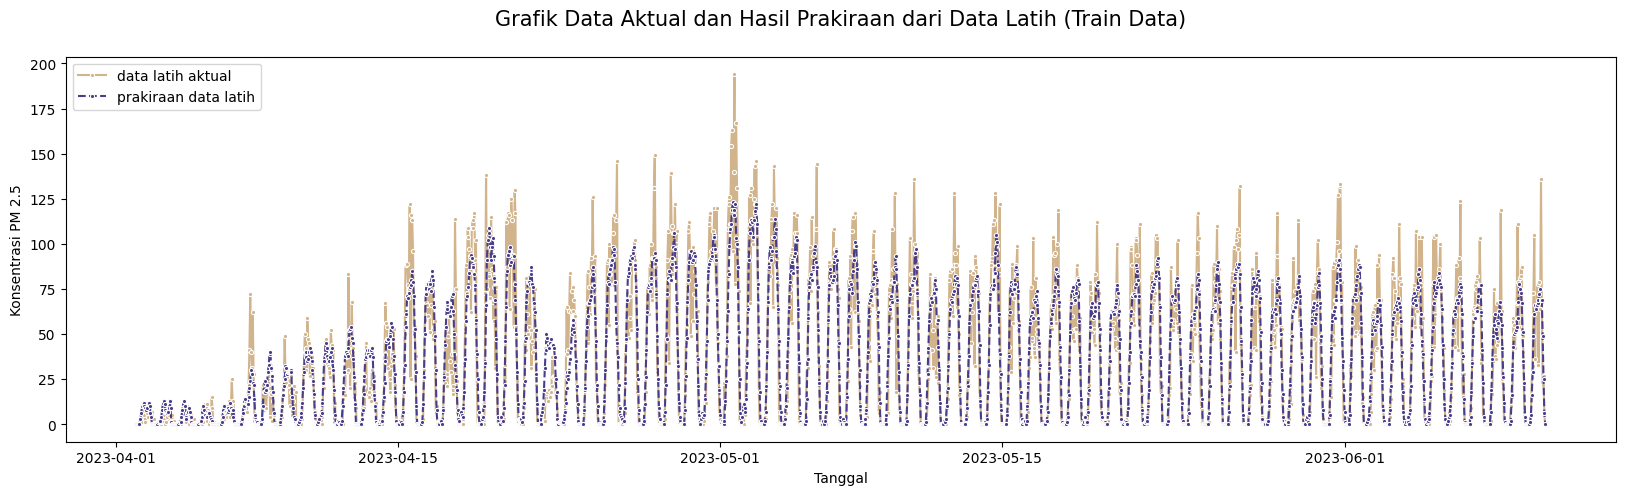

In [35]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [36]:
rmse = mean_squared_error(df_train['Forecast_T1'], df_train['Actual_T1'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T1'], df_train['Actual_T1'])
mape = mean_absolute_percentage_error(df_train['Forecast_T1'], df_train['Actual_T1'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  16.59
MAE:  10.62


#### Visualisasi T2

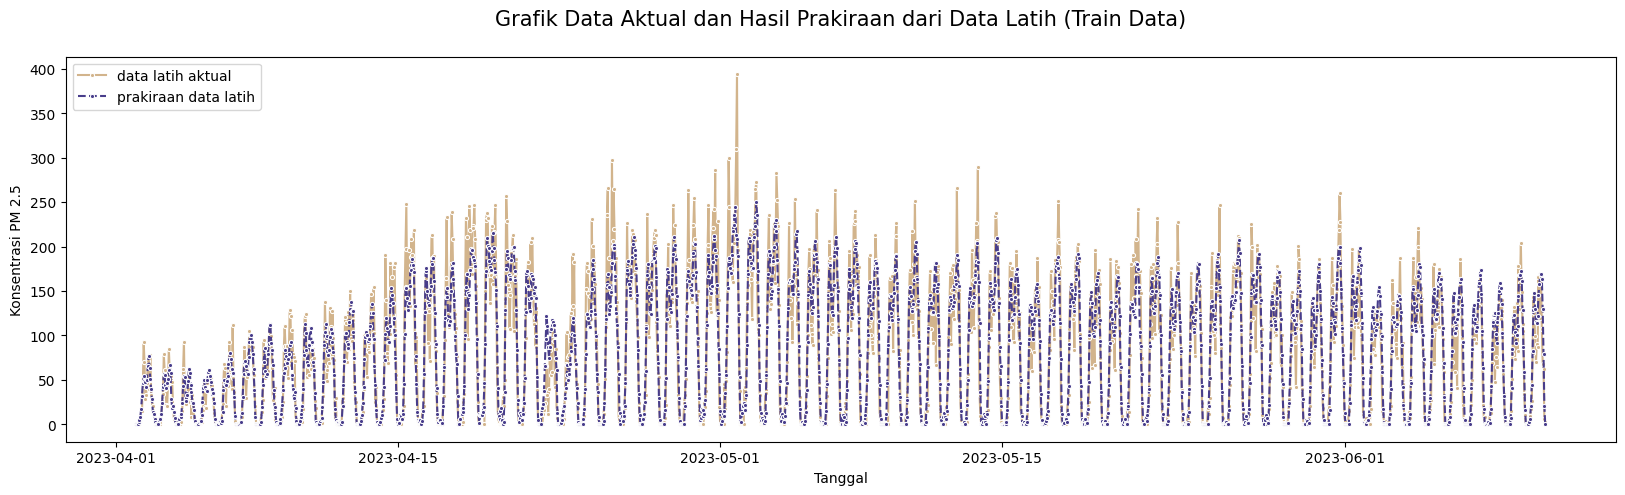

In [37]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [38]:
rmse = mean_squared_error(df_train['Forecast_T2'], df_train['Actual_T2'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T2'], df_train['Actual_T2'])
mape = mean_absolute_percentage_error(df_train['Forecast_T2'], df_train['Actual_T2'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  27.23
MAE:  18.52


#### Visualisasi T3

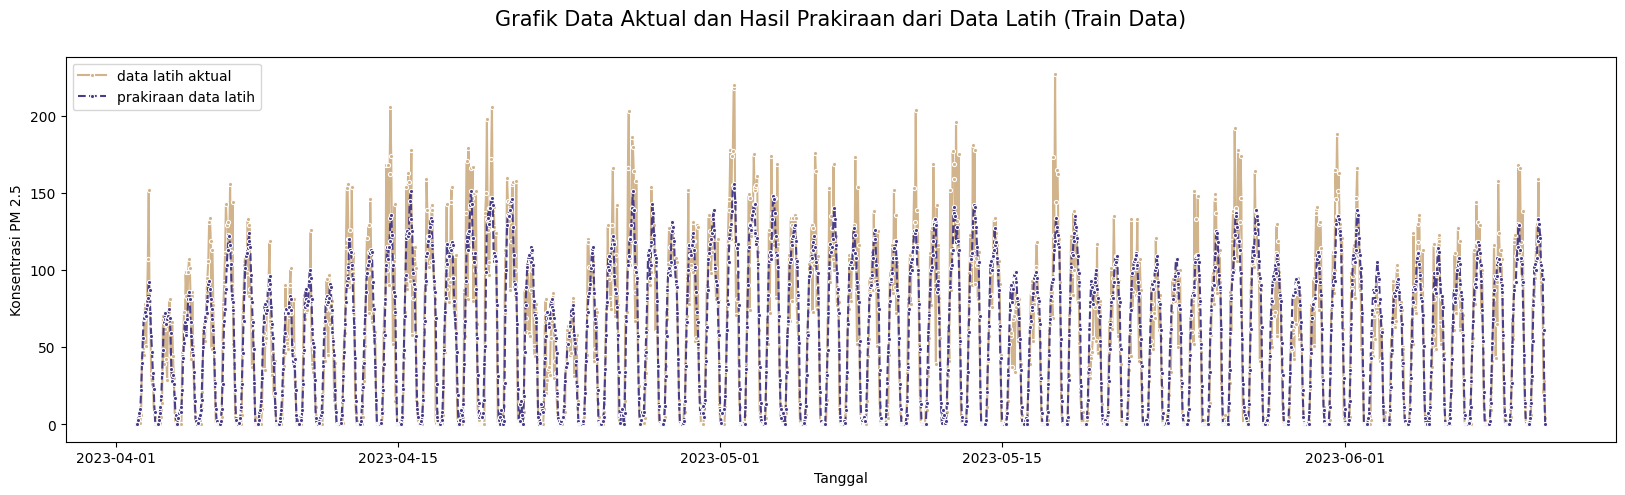

In [39]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_train, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_train, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (Train Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [40]:
rmse = mean_squared_error(df_train['Forecast_T3'], df_train['Actual_T3'], squared=False)
mae = mean_absolute_error(df_train['Forecast_T3'], df_train['Actual_T3'])
mape = mean_absolute_percentage_error(df_train['Forecast_T3'], df_train['Actual_T3'])

print('Forecast Train accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast Train accuracy
RMSE:  21.41
MAE:  14.56


### Prediction with validation data

In [41]:
forecast_val_data = model_forecast(modelBiGRU, paxBMS_val_scaled, n_lookback, 1)
print(forecast_val_data.shape)

forecast_val_data = forecast_val_data[:-1, 0]
print(forecast_val_data.shape)
print(paxBMS_val_scaled.shape[0]-n_lookback)
forecast_val_data

     23/Unknown - 0s 5ms/step

769/769 [==============================] - 4s 5ms/step
(769, 24, 3)
(768, 3)
768


array([[-1.1633204 , -1.3418947 , -1.2310321 ],
       [-1.1820031 , -1.4229444 , -1.3214074 ],
       [-1.1072721 , -1.266657  , -1.2496762 ],
       ...,
       [-0.03114338,  0.20797843,  0.4538079 ],
       [-0.39549097, -0.2522427 , -0.11620615],
       [-0.8881154 , -0.8764421 , -0.7479007 ]], dtype=float32)

In [42]:
paxBMS_val[24:]

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       ...,
       [ 28, 102,  96],
       [  9,  19,  39],
       [  1,   0,  11]], dtype=int64)

In [43]:
original = inverse_normalize_series(forecast_val_data, paxBMS_val)
original

array([[ -2., -10.,  -3.],
       [ -3., -14.,  -7.],
       [ -0.,  -5.,  -4.],
       ...,
       [ 35.,  79.,  78.],
       [ 23.,  53.,  51.],
       [  7.,  17.,  21.]])

In [44]:
actual = np.squeeze(paxBMS_val[-forecast_val_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(768, 3)
[[0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]
 [0 0 0]]


In [45]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

768


array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       ...,
       [35, 79, 78],
       [23, 53, 51],
       [ 7, 17, 21]])

In [46]:
df_val = pd.DataFrame()
df_val['Date'] = data_val[-forecast_val_data.shape[0]:].index

df_val['Actual_T1'] = actual[:,0]
df_val['Actual_T2'] = actual[:,1]
df_val['Actual_T3'] = actual[:,2]

df_val['Forecast_T1'] = corrected_forecast[:,0]
df_val['Forecast_T2'] = corrected_forecast[:,1]
df_val['Forecast_T3'] = corrected_forecast[:,2]

df_val

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-06-12 00:00:00          0          0          0            0  \
1   2023-06-12 01:00:00          0          0          0            0   
2   2023-06-12 02:00:00          0          0          0            0   
3   2023-06-12 03:00:00          0          0          0            3   
4   2023-06-12 04:00:00          0          0          0            4   
..                  ...        ...        ...        ...          ...   
763 2023-07-13 19:00:00         49        137        118           63   
764 2023-07-13 20:00:00         71        149        148           45   
765 2023-07-13 21:00:00         28        102         96           35   
766 2023-07-13 22:00:00          9         19         39           23   
767 2023-07-13 23:00:00          1          0         11            7   

     Forecast_T2  Forecast_T3  
0              0            0  
1              0            0  
2              0            0  
3              1            1  
4              1            3  
..           ...          ...  
763          131           93  
764          103           86  
765           79           78  
766           53           51  
767           17           21  

[768 rows x 7 columns]

### Visualisasi validation data

#### Visualisasi T1

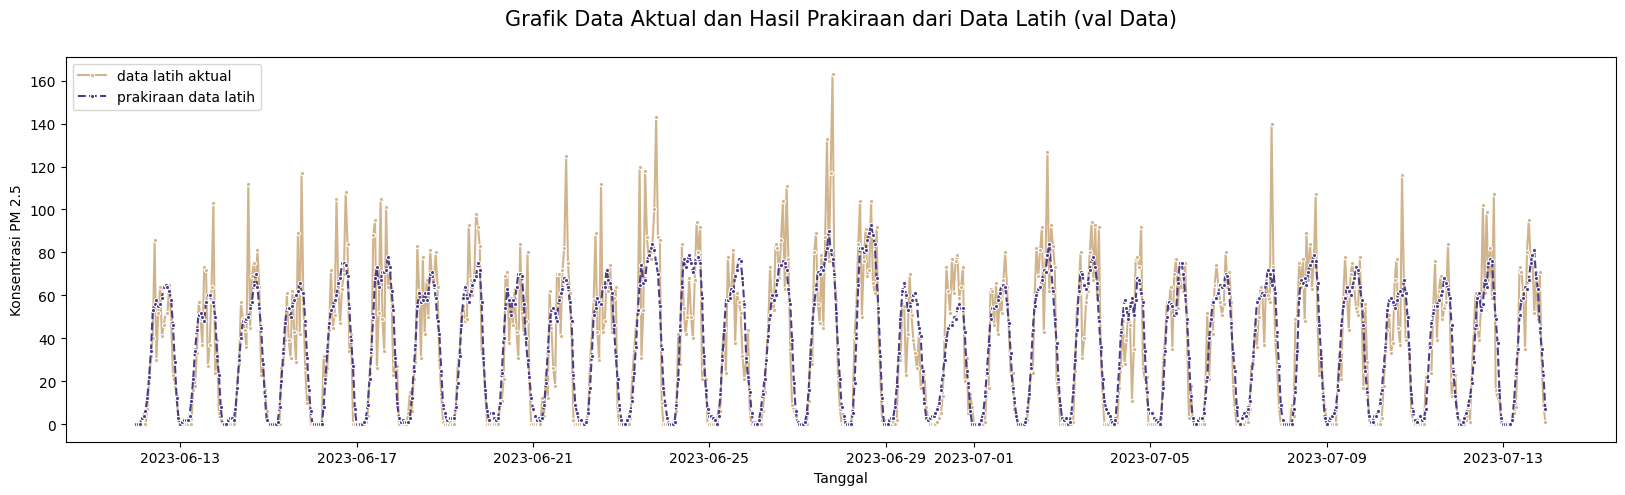

In [47]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [48]:
rmse = mean_squared_error(df_val['Forecast_T1'], df_val['Actual_T1'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T1'], df_val['Actual_T1'])
mape = mean_absolute_percentage_error(df_val['Forecast_T1'], df_val['Actual_T1'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  16.53
MAE:  11.5


#### Visualisasi T2

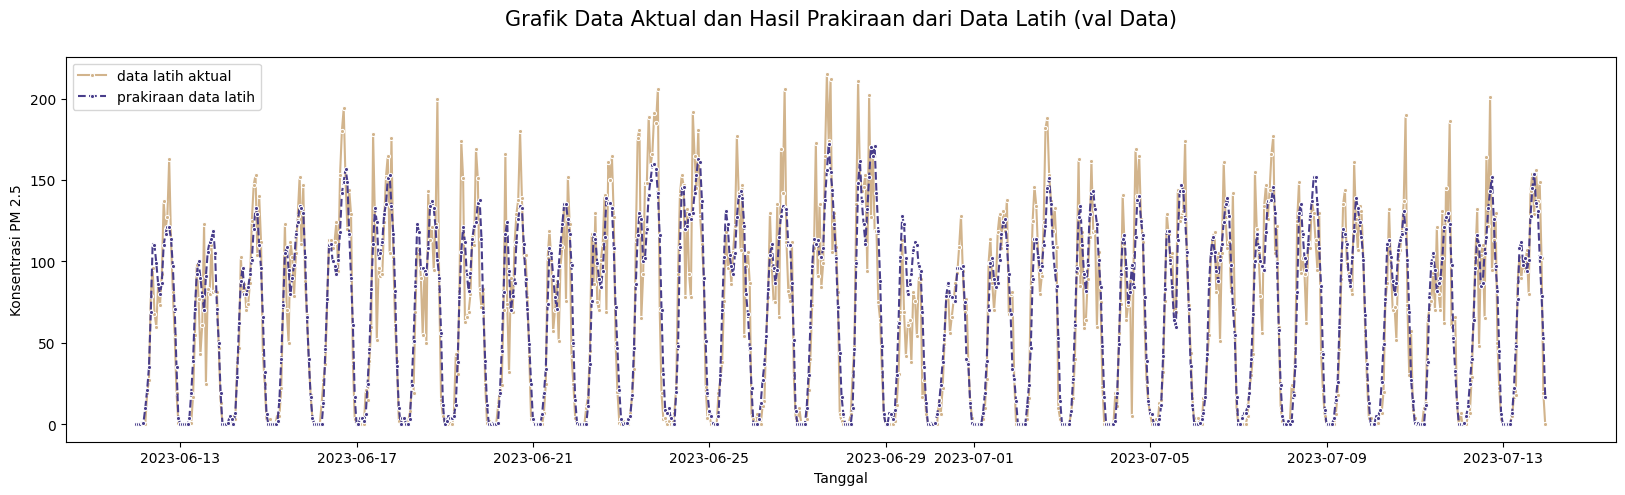

In [49]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [50]:
rmse = mean_squared_error(df_val['Forecast_T2'], df_val['Actual_T2'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T2'], df_val['Actual_T2'])
mape = mean_absolute_percentage_error(df_val['Forecast_T2'], df_val['Actual_T2'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  23.71
MAE:  16.49


#### Visualisasi T3

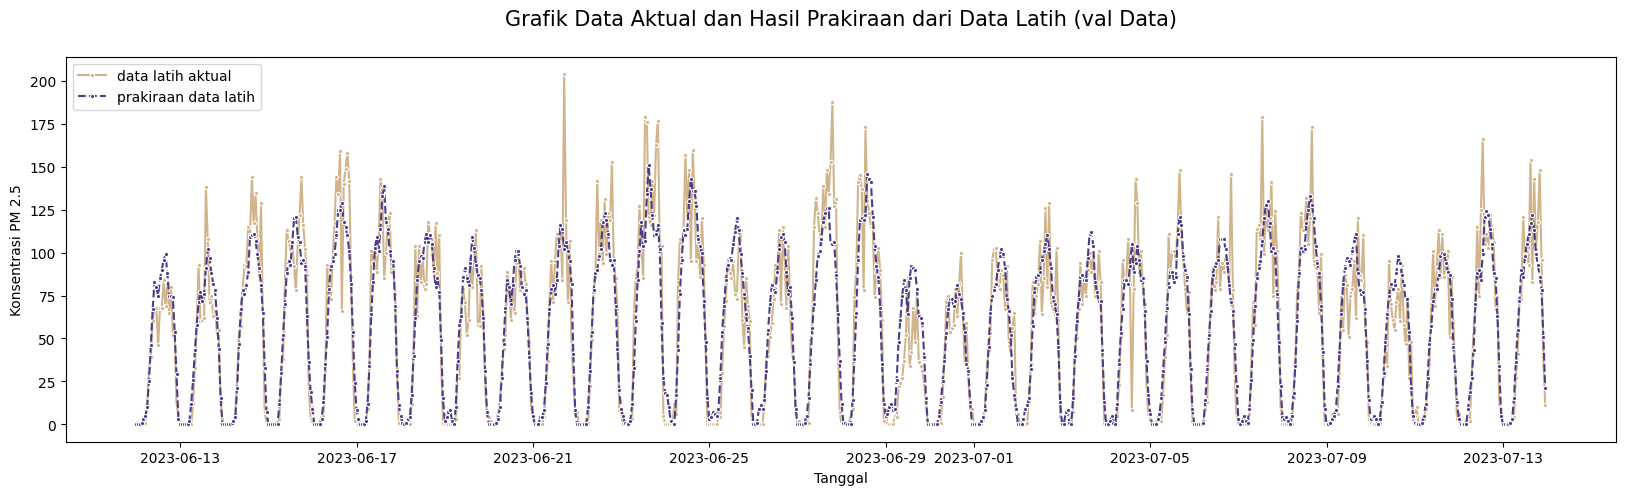

In [51]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_val, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_val, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (val Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [52]:
rmse = mean_squared_error(df_val['Forecast_T3'], df_val['Actual_T3'], squared=False)
mae = mean_absolute_error(df_val['Forecast_T3'], df_val['Actual_T3'])
mape = mean_absolute_percentage_error(df_val['Forecast_T3'], df_val['Actual_T3'])

print('Forecast val accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast val accuracy
RMSE:  19.57
MAE:  13.43


### Prediction with testing data

In [53]:
forecast_test_data = model_forecast(modelBiGRU, paxBMS_test_scaled, n_lookback, 1)
print(forecast_test_data.shape)

forecast_test_data = forecast_test_data[:-1, 0]
print(forecast_test_data.shape)
print(paxBMS_test_scaled.shape[0]-n_lookback)
forecast_test_data

     22/Unknown - 0s 5ms/step

121/121 [==============================] - 1s 5ms/step
(121, 24, 3)
(120, 3)
120


array([[-1.0189006 , -1.0924942 , -1.056335  ],
       [-1.0775881 , -1.1500878 , -1.1377302 ],
       [-1.1102852 , -1.124605  , -1.0919946 ],
       [-1.132845  , -1.1747941 , -1.0554506 ],
       [-1.1170665 , -1.1916212 , -1.0839003 ],
       [-0.9771535 , -1.0899714 , -1.0933778 ],
       [-0.7885357 , -0.7525622 , -0.8334409 ],
       [-0.36204758, -0.24492784, -0.31383777],
       [ 0.09532004,  0.48215967,  0.22235154],
       [ 0.6075997 ,  1.1078451 ,  0.66332877],
       [ 0.818921  ,  1.0638924 ,  0.8184839 ],
       [ 0.91567343,  0.8482122 ,  1.1414344 ],
       [ 1.1331316 ,  0.85151374,  1.2530298 ],
       [ 1.2164066 ,  0.85729146,  1.4034469 ],
       [ 1.2118266 ,  0.92073387,  1.5478531 ],
       [ 1.1250288 ,  1.0935942 ,  1.5698489 ],
       [ 0.7932005 ,  0.8431105 ,  0.9475543 ],
       [ 0.85310036,  1.2088922 ,  0.8957069 ],
       [ 0.909619  ,  1.3463782 ,  0.86182237],
       [ 0.879823  ,  1.2809285 ,  0.6449348 ],
       [ 0.27659908,  0.66796577,  0.330

In [54]:
paxBMS_test[24:]

array([[  0,   0,   1],
       [  0,   0,   1],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  0,   9,   3],
       [  3,  23,   8],
       [ 36,  40,  27],
       [ 49,  75,  79],
       [ 69,  95,  71],
       [ 72,  83, 188],
       [ 70, 119, 111],
       [ 74,  95, 110],
       [ 35, 105, 132],
       [ 46,  85,  87],
       [ 61,  11,  20],
       [ 44, 110,  85],
       [ 72, 130, 148],
       [ 77, 133,  68],
       [ 33,  75,  82],
       [ 95, 138,  79],
       [ 16,  54,  46],
       [ 10,  52,  42],
       [  0,   0,   2],
       [  0,   6,   3],
       [  0,   6,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  1,   0,   0],
       [  3,  20,   0],
       [ 14,   7,   4],
       [ 14,  35,  42],
       [ 29,  55,  94],
       [ 75, 129,  79],
       [103,  98,  98],
       [ 63,  66, 102],
       [ 67,  84,  85],
       [ 93,  93,  77],
       [ 82,  53, 114],
       [ 98, 137, 136],
       [ 61, 125, 113],
       [ 82, 162

In [55]:
original = inverse_normalize_series(forecast_test_data, paxBMS_test)
original

array([[  3.,   3.,   7.],
       [  1.,   0.,   3.],
       [  0.,   2.,   5.],
       [ -0.,  -1.,   7.],
       [  0.,  -2.,   5.],
       [  4.,   4.,   5.],
       [ 10.,  21.,  18.],
       [ 23.,  46.,  43.],
       [ 37.,  83.,  68.],
       [ 52., 115.,  90.],
       [ 59., 112.,  97.],
       [ 62., 102., 113.],
       [ 68., 102., 118.],
       [ 71., 102., 125.],
       [ 71., 105., 132.],
       [ 68., 114., 133.],
       [ 58., 101., 103.],
       [ 60., 120., 101.],
       [ 62., 127.,  99.],
       [ 61., 123.,  89.],
       [ 42.,  92.,  74.],
       [ 41.,  81.,  67.],
       [ 15.,  32.,  35.],
       [  5.,   9.,  11.],
       [  2.,  -5.,   2.],
       [  2.,   1.,  -0.],
       [  8.,  11.,   0.],
       [  8.,   8.,   7.],
       [  9.,   2.,   7.],
       [  8.,   8.,   9.],
       [ 13.,  17.,  21.],
       [ 20.,  34.,  39.],
       [ 31.,  66.,  60.],
       [ 45.,  98.,  77.],
       [ 60., 118., 102.],
       [ 69., 118., 105.],
       [ 64.,  99., 103.],
 

In [56]:
actual = np.squeeze(paxBMS_test[-forecast_test_data.shape[0]:])
print(actual.shape)
print(actual[:5])

(120, 3)
[[0 0 1]
 [0 0 1]
 [0 0 0]
 [0 0 0]
 [1 0 0]]


In [57]:
corrected_forecast = []
for i in original:
    temp = []
    for j in i:
        if j < 0:
            temp.append(0)
        elif j >= 0:
            _temp = np.ceil(j)
            temp.append(int(_temp))        
    corrected_forecast.append(temp)


corrected_forecast = np.array(corrected_forecast)
print(len(corrected_forecast))
corrected_forecast

120


array([[  3,   3,   7],
       [  1,   0,   3],
       [  0,   2,   5],
       [  0,   0,   7],
       [  0,   0,   5],
       [  4,   4,   5],
       [ 10,  21,  18],
       [ 23,  46,  43],
       [ 37,  83,  68],
       [ 52, 115,  90],
       [ 59, 112,  97],
       [ 62, 102, 113],
       [ 68, 102, 118],
       [ 71, 102, 125],
       [ 71, 105, 132],
       [ 68, 114, 133],
       [ 58, 101, 103],
       [ 60, 120, 101],
       [ 62, 127,  99],
       [ 61, 123,  89],
       [ 42,  92,  74],
       [ 41,  81,  67],
       [ 15,  32,  35],
       [  5,   9,  11],
       [  2,   0,   2],
       [  2,   1,   0],
       [  8,  11,   0],
       [  8,   8,   7],
       [  9,   2,   7],
       [  8,   8,   9],
       [ 13,  17,  21],
       [ 20,  34,  39],
       [ 31,  66,  60],
       [ 45,  98,  77],
       [ 60, 118, 102],
       [ 69, 118, 105],
       [ 64,  99, 103],
       [ 60,  83, 103],
       [ 62,  80, 100],
       [ 62,  85,  98],
       [ 77, 127, 117],
       [ 77, 130

In [58]:
df_test = pd.DataFrame()
df_test['Date'] = data_test[-forecast_test_data.shape[0]:].index

df_test['Actual_T1'] = actual[:,0]
df_test['Actual_T2'] = actual[:,1]
df_test['Actual_T3'] = actual[:,2]

df_test['Forecast_T1'] = corrected_forecast[:,0]
df_test['Forecast_T2'] = corrected_forecast[:,1]
df_test['Forecast_T3'] = corrected_forecast[:,2]

df_test

Date  Actual_T1  Actual_T2  Actual_T3  Forecast_T1   
0   2023-07-15 00:00:00          0          0          1            3  \
1   2023-07-15 01:00:00          0          0          1            1   
2   2023-07-15 02:00:00          0          0          0            0   
3   2023-07-15 03:00:00          0          0          0            0   
4   2023-07-15 04:00:00          1          0          0            0   
..                  ...        ...        ...        ...          ...   
115 2023-07-19 19:00:00         73        119         65           40   
116 2023-07-19 20:00:00         69         92         90           36   
117 2023-07-19 21:00:00         28         25         47           31   
118 2023-07-19 22:00:00          2          9         31           14   
119 2023-07-19 23:00:00          1          3          4            4   

     Forecast_T2  Forecast_T3  
0              3            7  
1              0            3  
2              2            5  
3              0            7  
4              0            5  
..           ...          ...  
115           84           79  
116           72           73  
117           62           58  
118           26           25  
119            0            0  

[120 rows x 7 columns]

In [76]:
# total_actualT1 = df_test[df_test['Date'] >= '2023-07-19']['Actual_T1'].sum()
# print(total_actualT1)

# total_forecastT1 = df_test[df_test['Date'] >= '2023-07-19']['Forecast_T1'].sum()
# print(total_forecastT1)

# print('selisih =', total_actualT1-total_forecastT1)
# print(((total_actualT1-total_forecastT1)/total_forecastT1) * 100, '%')

### Visualisasi testing data

#### Visualisasi T1

In [77]:
total_actualT1 = df_test['Actual_T1'].sum()
print(total_actualT1)

total_forecastT1 = df_test['Forecast_T1'].sum()
print(total_forecastT1)

print('selisih =', total_actualT1-total_forecastT1)
print(((total_actualT1-total_forecastT1)/total_forecastT1) * 100, '%')

4133
4129
selisih = 4
0.09687575684185032 %


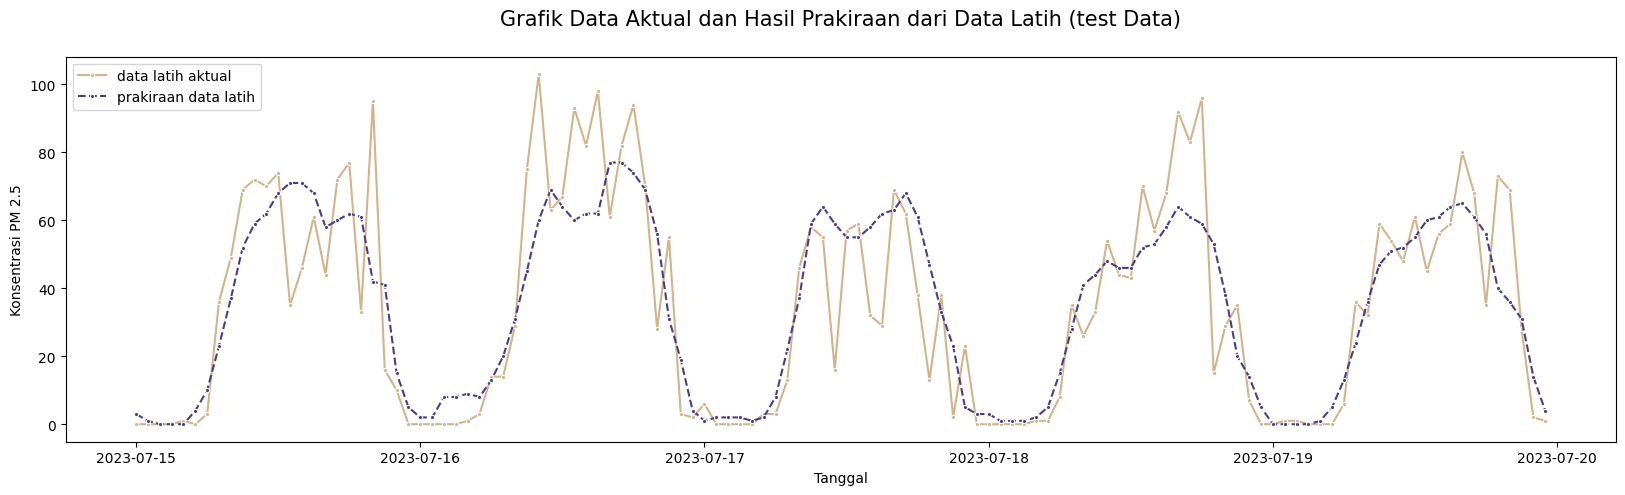

In [59]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T1", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T1", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [60]:
rmse = mean_squared_error(df_test['Forecast_T1'], df_test['Actual_T1'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T1'], df_test['Actual_T1'])
mape = mean_absolute_percentage_error(df_test['Forecast_T1'], df_test['Actual_T1'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  16.22
MAE:  11.4


#### Visualisasi T2

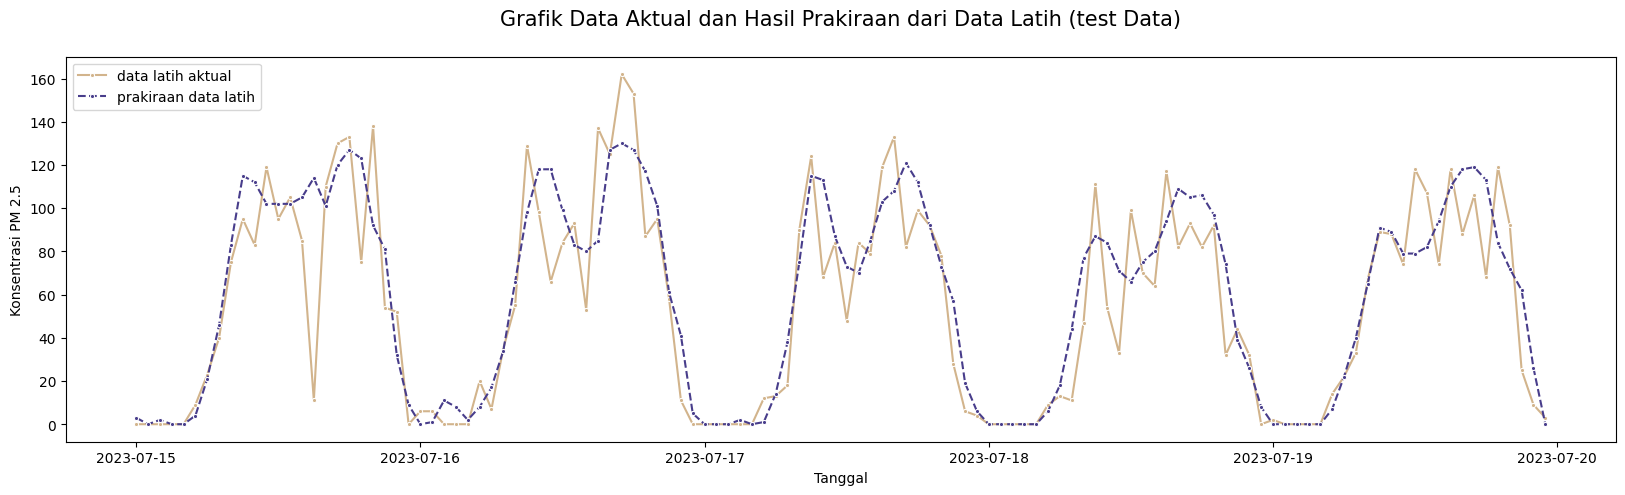

In [61]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T2", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T2", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [62]:
rmse = mean_squared_error(df_test['Forecast_T2'], df_test['Actual_T2'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T2'], df_test['Actual_T2'])
mape = mean_absolute_percentage_error(df_test['Forecast_T2'], df_test['Actual_T2'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  21.85
MAE:  14.89


#### Visualisasi T3

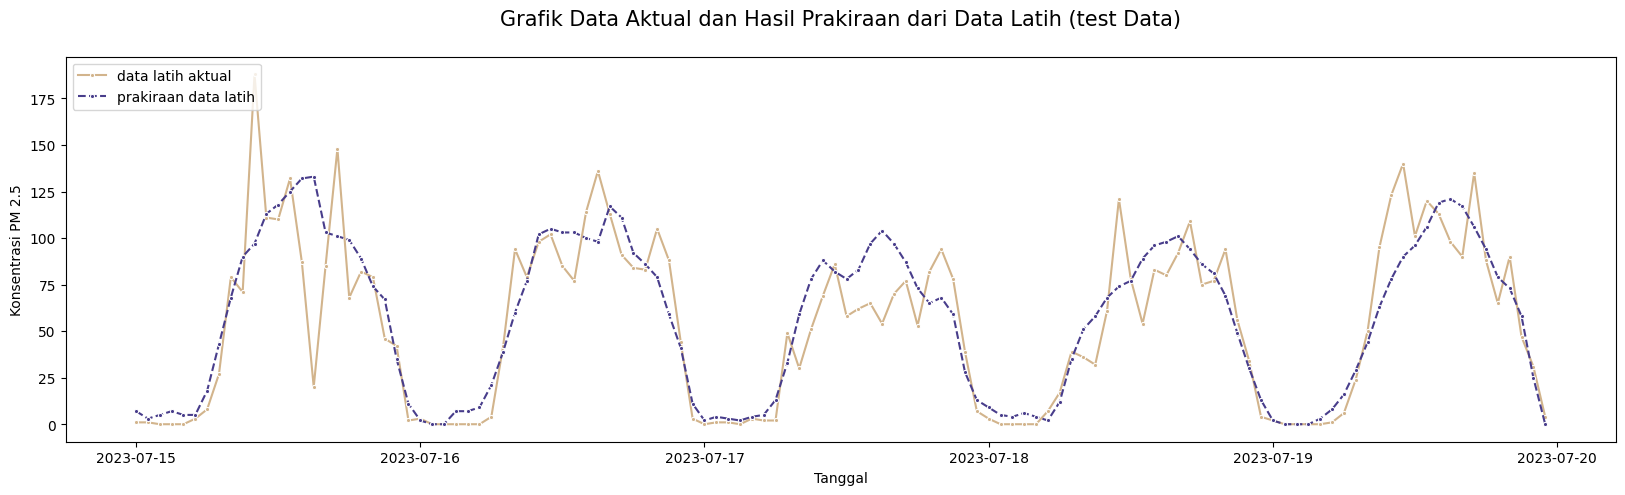

In [63]:
plt.subplots(figsize=(20, 5))
ax = sns.lineplot(x="Date", y="Actual_T3", data=df_test, 
                    label="data latih aktual", marker='.', color = 'tan')
ax = sns.lineplot(x="Date", y="Forecast_T3", data=df_test, 
                    label="prakiraan data latih", marker='.', linestyle="--", color = 'darkslateblue')
plt.xlabel('Tanggal'); plt.ylabel('Konsentrasi PM 2.5')
plt.title("Grafik Data Aktual dan Hasil Prakiraan dari Data Latih (test Data)\n", fontsize = 15)
plt.legend(loc='upper left')

In [64]:
rmse = mean_squared_error(df_test['Forecast_T3'], df_test['Actual_T3'], squared=False)
mae = mean_absolute_error(df_test['Forecast_T3'], df_test['Actual_T3'])
mape = mean_absolute_percentage_error(df_test['Forecast_T3'], df_test['Actual_T3'])

print('Forecast test accuracy')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast test accuracy
RMSE:  22.22
MAE:  14.68
